# Cluster Gender Changes

This notebook audits for significant changes in cluster gender
annotations, to allow us to detect the significance of shifts over time.
It depends on the aligned cluster identities in
`isbn-version-clusters.parquet`.

In [1]:
from pathlib import Path
from functools import reduce

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

Define the versions we care about:

In [3]:
versions = ['pgsql', '2022-03-2.0', '2022-07', '2022-10', '2022-11-2.1', '2023-07', '2025-06-3.0', 'current']

Load the aligned ISBNs:

In [4]:
isbn_clusters = pd.read_parquet('isbn-version-clusters.parquet')
isbn_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44866744 entries, 0 to 44866743
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   isbn         object 
 1   isbn_id      int32  
 2   current      float64
 3   2025-06-3.0  float64
 4   2023-07      float64
 5   2022-11-2.1  float64
 6   2022-10      float64
 7   2022-07      float64
 8   2022-03-2.0  float64
 9   pgsql        float64
dtypes: float64(8), int32(1), object(1)
memory usage: 3.2+ GB

## Different Genders

How many clusters changed gender?

To get started, we need a list of genders in order.

In [5]:
genders = [
    'ambiguous', 'female', 'male', 'unknown',
    'no-author-rec', 'no-book-author', 'no-book', 'absent'
]

Let’s make a function to read gender info:

In [6]:
def read_gender(path, map_file=None):
    cg = pl.scan_parquet(path)
    cg = cg.select([
        pl.col('cluster').cast(pl.Int32),
        pl.when(pl.col('gender') == pl.lit('no-loc-author'))
            .then(pl.lit('no-book-author'))
            .when(pl.col('gender') == pl.lit('no-viaf-author'))
            .then(pl.lit('no-author-rec'))
            .otherwise(pl.col('gender'))
            .cast(pl.Categorical)
            .alias('gender')
    ])
    if map_file is not None:
        map = pl.scan_parquet(map_file)
        cg = cg.join(map, on='cluster', how='left')
        cg = cg.select([
            pl.col('common').alias('cluster'),
            pl.col('gender')
        ])
    return cg

Read each data source’s gender info and map to common cluster IDs:

In [7]:
gender_cc = {
    v: read_gender(f'{v}/cluster-genders.parquet', f'{v}/cluster-map.parquet')
    for v in versions if v != 'current'
}
gender_cc['current'] = read_gender('../book-links/cluster-genders.parquet')

Set up a sequence of frames for merging:

In [8]:
to_merge = [
    gender_cc[v].select([
        pl.col('cluster'),
        pl.col('gender').alias(v)
    ]).unique()
    for v in versions
]

Merge and collect results:

In [9]:
cluster_genders = reduce(lambda df1, df2: df1.join(df2, on='cluster', how='outer_coalesce'), to_merge)
cluster_genders = cluster_genders.collect()

/tmp/ipykernel_4174369/2981784951.py:1: DeprecationWarning: Use of `how='outer_coalesce'` should be replaced with `how='full', coalesce=True`.
  cluster_genders = reduce(lambda df1, df2: df1.join(df2, on='cluster', how='outer_coalesce'), to_merge)

For unclear reasons, a few versions have a null cluster. Drop that.

In [10]:
cluster_genders = cluster_genders.filter(cluster_genders['cluster'].is_not_null())

Now we will convert to Pandas and fix missing values:

In [11]:
cluster_genders = cluster_genders.to_pandas().set_index('cluster')

Now we’ll unify the categories and their orders:

In [12]:
cluster_genders = cluster_genders.apply(lambda vdf: vdf.cat.set_categories(genders, ordered=True))
cluster_genders.fillna('absent', inplace=True)
cluster_genders.head()

,pgsql,2022-03-2.0,2022-07,2022-10,2022-11-2.1,2023-07,2025-06-3.0,current
cluster,,,,,,,,
101559774,absent,absent,absent,absent,absent,absent,absent,no-book-author
452208798,no-book-author,no-book,no-book,no-book-author,no-book-author,no-book-author,no-book-author,no-book-author
127012979,absent,absent,no-book-author,no-book-author,no-book-author,no-book-author,no-book-author,no-book-author
117407548,no-book-author,no-book-author,no-book-author,no-book-author,no-book-author,no-book-author,no-book-author,no-book-author
102777110,female,female,female,female,female,female,female,female


Let’s save this file for further analysis:

In [13]:
cluster_genders.to_parquet('cluster-version-genders.parquet', compression='zstd')

## PostgreSQL to Current

Now we are ready to actually compare cluster genders across categories.
Let’s start by comparing original data (PostgreSQL) to current:

In [14]:
ct = cluster_genders[['pgsql', 'current']].value_counts().unstack()
ct = ct.reindex(labels=genders, columns=genders)
ct

current,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
pgsql,,,,,,,,
ambiguous,95825.0,4815.0,11222.0,2398.0,1660.0,3175.0,4.0,5109.0
female,17856.0,1106202.0,1224.0,19534.0,9317.0,256.0,31.0,39691.0
male,30709.0,3094.0,3472004.0,28199.0,30960.0,808.0,155.0,79287.0
unknown,3222.0,130124.0,230286.0,1501820.0,19732.0,21.0,12.0,15158.0
no-author-rec,10753.0,60165.0,332493.0,230073.0,1385651.0,1097.0,125.0,15337.0
no-book-author,9084.0,114768.0,222317.0,132370.0,213811.0,2445284.0,898251.0,278188.0
no-book,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
absent,130365.0,1087795.0,2667206.0,1177309.0,4962030.0,17648931.0,728440.0,358958.0


In [15]:
ctf = ct.divide(ct.sum(axis='columns'), axis='rows')
def style_row(row):
    styles = []
    for col, val in zip(row.index, row.values):
        if col == row.name:
            styles.append('font-weight: bold')
        elif val > 0.1:
            styles.append('color: red')
        else:
            styles.append(None)
    return styles
ctf.style.apply(style_row, 'columns')

current,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
pgsql,,,,,,,,
ambiguous,0.771488,0.038766,0.090348,0.019306,0.013365,0.025562,0.000032,0.041133
female,0.014953,0.926381,0.001025,0.016359,0.007802,0.000214,0.000026,0.033239
male,0.008424,0.000849,0.952482,0.007736,0.008493,0.000222,0.000043,0.021751
unknown,0.001695,0.068473,0.121179,0.790276,0.010383,0.000011,0.000006,0.007976
no-author-rec,0.005282,0.029555,0.163332,0.113019,0.680677,0.000539,0.000061,0.007534
no-book-author,0.002106,0.026603,0.051533,0.030683,0.049561,0.566816,0.208214,0.064484
no-book,nan,nan,nan,nan,nan,nan,nan,nan
absent,0.004533,0.037822,0.092737,0.040934,0.172526,0.613640,0.025327,0.012481


Most of the change is coming from clusters absent in the original but
present in the new.

There are also quite a few that had no book author in PGSQL, but no book
in the current data - not sure what’s up with that. Let’s look at more
crosstabs.

In [16]:
def gender_crosstab(old, new, fractional=True):
    ct = cluster_genders[[old, new]].value_counts().unstack()
    ct = ct.reindex(labels=genders, columns=genders)

    if fractional:
        ctf = ct.divide(ct.sum(axis='columns'), axis='rows')
        return ctf
    else:
        return ct

In [17]:
def plot_gender(set):
    cluster_genders[set].value_counts().sort_index().plot.barh()
    plt.title(f'Gender Distribution in {set}')

## PostgreSQL to March 2022 (2.0 release)

This marks the change from PostgreSQL to pure-Rust.

In [18]:
ct = gender_crosstab('pgsql', '2022-03-2.0')
ct.style.apply(style_row, 'columns')

2022-03-2.0,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
pgsql,,,,,,,,
ambiguous,0.977924,0.002955,0.013928,0.000636,0.000878,nan,nan,0.003679
female,0.002190,0.993945,0.000001,0.000301,0.000430,0.000003,0.000005,0.003125
male,0.000591,0.000000,0.995938,0.000528,0.000796,0.000002,0.000014,0.002131
unknown,0.000043,0.002759,0.005304,0.988899,0.001953,0.000001,0.000003,0.001039
no-author-rec,0.000104,0.007919,0.049969,0.031480,0.908599,nan,0.000008,0.001921
no-book-author,0.000002,0.000051,0.000200,0.000108,0.000051,0.649173,0.335017,0.015397
no-book,nan,nan,nan,nan,nan,nan,nan,nan
absent,0.000006,0.000046,0.000239,0.000112,0.000167,0.001884,0.000066,0.997481


This is where we change from no-book-author to no-book for a bunch of
books; otherwise things are pretty consistent. This major change is
likely a result of changes that count more books and book clusters - we
had some inner joins in the PostgreSQL version that were questionable,
and in particular we didn’t really cluster solo ISBNs but now we do. But
now, if we have a solo ISBN from rating data, it gets a cluster with no
book record instead of being excluded from the clustering.

Let’s look at the distribution of statuses for each, starting with
PostgreSQL:

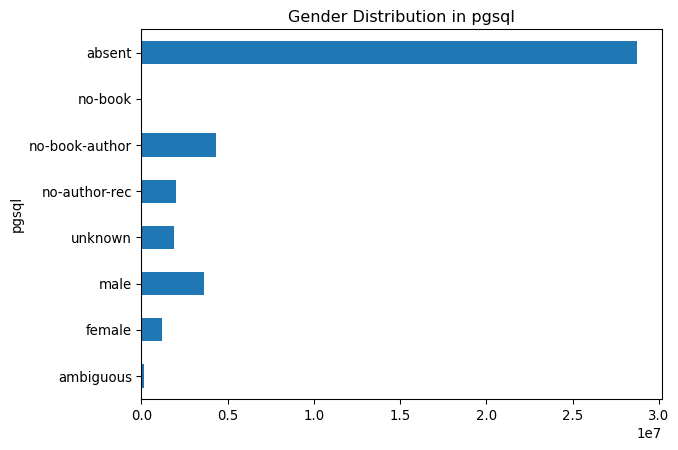

In [19]:
plot_gender('pgsql')

And the Rust version:

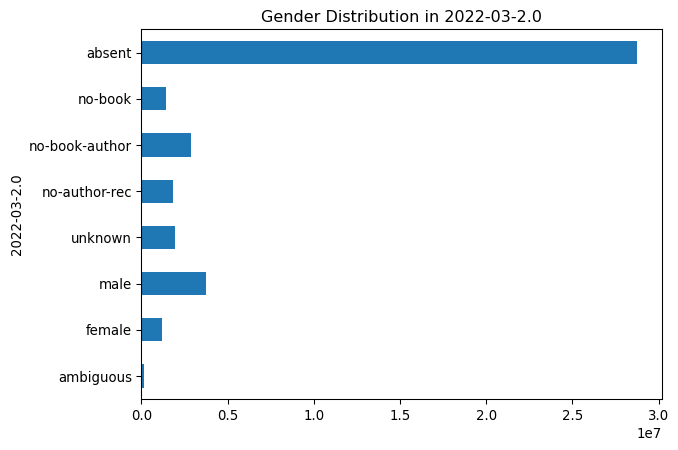

In [20]:
plot_gender('2022-03-2.0')

## March to July 2022

We updated a lot of data files and changed the name and ISBN parsing
logic.

In [21]:
ct = gender_crosstab('2022-03-2.0', '2022-07')
ct.style.apply(style_row, 'columns')

2022-07,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2022-03-2.0,,,,,,,,
ambiguous,0.836228,0.035602,0.083587,0.014814,0.004862,0.000087,0.000016,0.024805
female,0.010065,0.963186,0.000487,0.007911,0.001253,0.000002,0.000012,0.017085
male,0.006706,0.000646,0.974636,0.003702,0.001364,0.000079,0.000014,0.012852
unknown,0.001901,0.040305,0.092947,0.856051,0.003411,0.000200,nan,0.005186
no-author-rec,0.003536,0.020630,0.108694,0.101641,0.762110,0.000009,0.000037,0.003344
no-book-author,0.002056,0.030443,0.057337,0.035301,0.056239,0.809983,0.000007,0.008635
no-book,0.000159,0.002344,0.005280,0.002742,0.004765,0.000634,0.980665,0.003411
absent,0.002109,0.018914,0.040477,0.014926,0.059121,0.003270,0.000001,0.861182


Mostly fine; some more are resolved, existing resolutions are pretty
consistent.

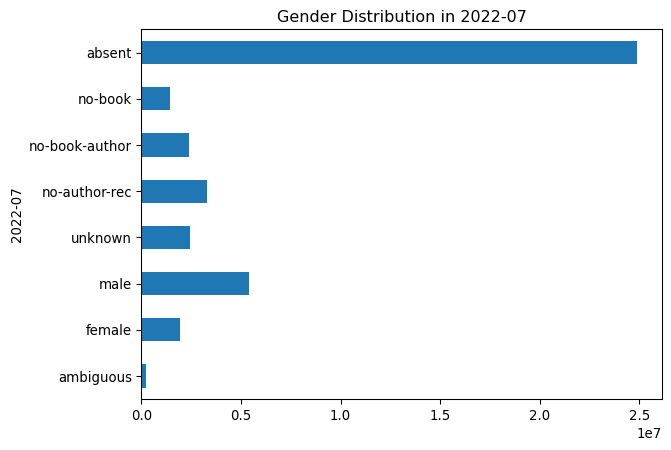

In [22]:
plot_gender('2022-07')

## July 2022 to Oct. 2022

We changed from DataFusion to Polars and made further ISBN and name
parsing changes.

In [23]:
ct = gender_crosstab('2022-07', '2022-10')
ct.style.apply(style_row, 'columns')

2022-10,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2022-07,,,,,,,,
ambiguous,0.989385,0.004969,0.003626,0.000336,0.001647,nan,nan,0.000036
female,nan,0.995099,nan,0.000361,0.004471,nan,nan,0.000070
male,0.000001,nan,0.994580,0.000431,0.004975,0.000000,nan,0.000012
unknown,nan,nan,nan,0.995467,0.004492,nan,nan,0.000042
no-author-rec,nan,0.000001,0.000003,0.000005,0.999823,0.000131,nan,0.000038
no-book-author,nan,0.000000,0.000001,0.000000,0.000000,0.996612,nan,0.003386
no-book,0.000004,0.000089,0.000035,0.000069,0.000094,0.198066,0.670216,0.131427
absent,nan,nan,nan,nan,nan,nan,nan,1.000000


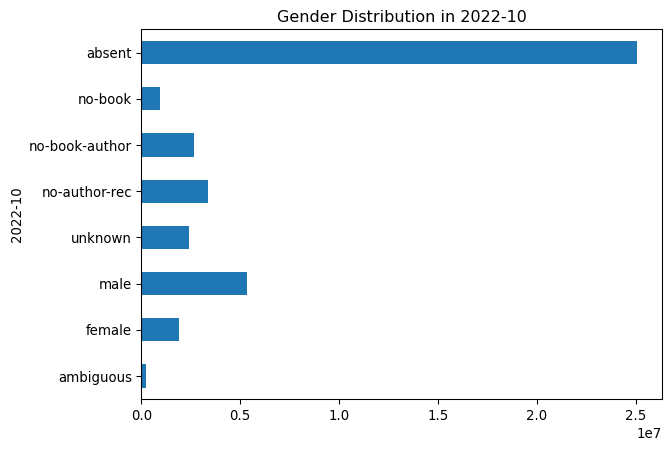

In [24]:
plot_gender('2022-10')

## Oct. 2022 to release 2.1 (Nov. 2022)

We added support for GoodReads CSV data and the Amazon 2018 rating CSV
files.

In [25]:
ct = gender_crosstab('2022-10', '2022-11-2.1')
ct.style.apply(style_row, 'columns')

2022-11-2.1,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2022-10,,,,,,,,
ambiguous,0.999995,nan,nan,nan,nan,nan,nan,0.000005
female,nan,0.999999,nan,nan,nan,nan,nan,0.000001
male,nan,nan,0.999999,nan,nan,nan,nan,0.000001
unknown,nan,nan,nan,0.999998,nan,nan,nan,0.000002
no-author-rec,nan,nan,nan,nan,0.999999,nan,nan,0.000001
no-book-author,nan,nan,nan,0.000000,nan,0.999982,nan,0.000017
no-book,nan,nan,nan,nan,nan,nan,1.000000,nan
absent,nan,0.000000,0.000000,0.000000,0.000000,0.000003,0.031489,0.968508


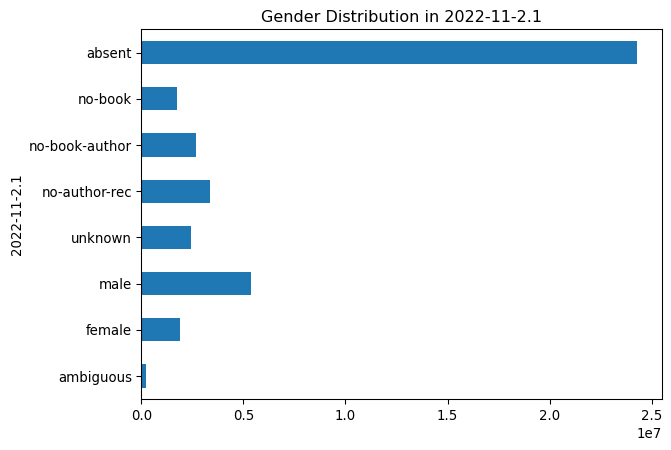

In [26]:
plot_gender('2022-11-2.1')

## Release 2.1 to Jul. 2023

We updated OpenLibrary and VIAF, and made some technical changes.

In [27]:
ct = gender_crosstab('2022-11-2.1', '2023-07')
ct.style.apply(style_row, 'columns')

2023-07,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2022-11-2.1,,,,,,,,
ambiguous,0.879459,0.006921,0.018915,0.001573,0.000239,0.074744,0.000009,0.018140
female,0.004892,0.975566,0.000307,0.004275,0.000396,0.000482,0.000002,0.014081
male,0.002249,0.000044,0.986211,0.001428,0.000497,0.001463,0.000005,0.008105
unknown,0.000266,0.019105,0.032232,0.945164,0.001086,0.000425,0.000000,0.001721
no-author-rec,0.000277,0.002896,0.007170,0.009781,0.975855,0.000360,0.000004,0.003658
no-book-author,0.000408,0.006223,0.011060,0.004081,0.006726,0.967637,0.000001,0.003864
no-book,0.000363,0.005640,0.011780,0.007411,0.024719,0.003812,0.940827,0.005448
absent,0.002871,0.019474,0.052188,0.024984,0.118197,0.013907,0.000001,0.768377


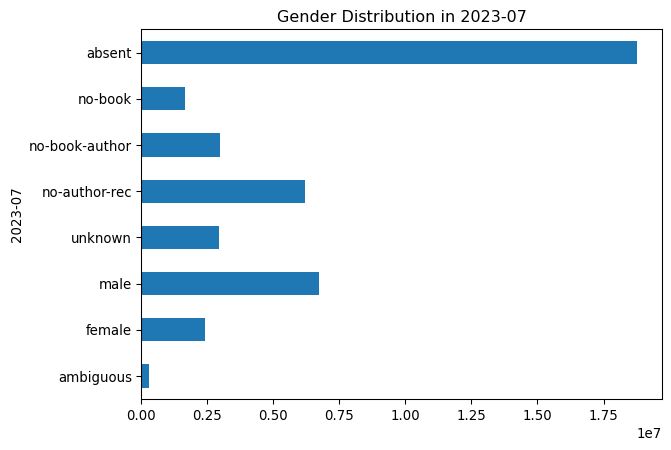

In [28]:
plot_gender('2023-07')

## Jul. 2023 to 3.0 (June 2025)

Mostly technical changes, along with updated OpenLibrary an dVIAF

In [29]:
ct = gender_crosstab('2023-07', '2025-06-3.0')
ct.style.apply(style_row, 'columns')

2025-06-3.0,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2023-07,,,,,,,,
ambiguous,0.916513,0.015526,0.040841,0.004112,0.000437,0.005387,nan,0.017185
female,0.003798,0.962122,0.000154,0.023668,0.000251,0.000479,0.000000,0.009528
male,0.002358,0.000091,0.980826,0.010716,0.000521,0.000440,0.000001,0.005047
unknown,0.000162,0.021824,0.023425,0.949053,0.002647,0.000014,nan,0.002876
no-author-rec,0.000114,0.001472,0.002637,0.005071,0.952103,0.000162,0.000015,0.038426
no-book-author,0.000084,0.000694,0.001612,0.000504,0.000704,0.994608,0.000000,0.001794
no-book,0.000037,0.000464,0.000953,0.000865,0.003197,0.001035,0.992922,0.000525
absent,0.000476,0.004847,0.013392,0.006382,0.036988,0.003447,0.000001,0.934466


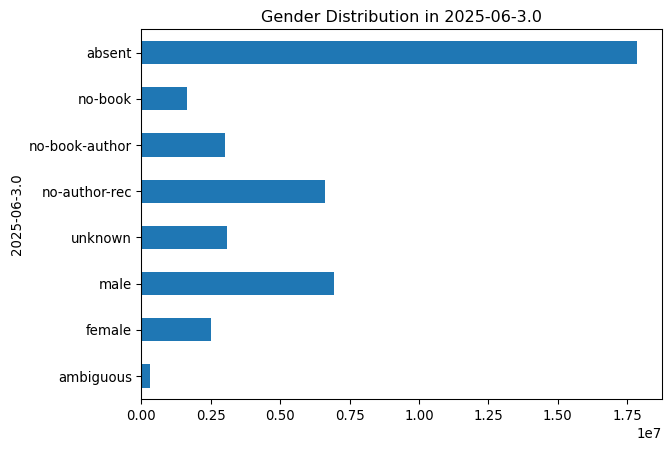

In [30]:
plot_gender('2025-06-3.0')

## Release 3.0 (June 2025) to Current

Mostly technical code updates.

In [31]:
ct = gender_crosstab('2025-06-3.0', 'current')
ct.style.apply(style_row, 'columns')

current,ambiguous,female,male,unknown,no-author-rec,no-book-author,no-book,absent
2025-06-3.0,,,,,,,,
ambiguous,1.000000,nan,nan,nan,nan,nan,nan,nan
female,nan,1.000000,nan,nan,nan,nan,nan,nan
male,nan,nan,1.000000,nan,nan,nan,nan,nan
unknown,nan,nan,nan,1.000000,nan,nan,nan,nan
no-author-rec,nan,nan,nan,nan,1.000000,nan,nan,nan
no-book-author,nan,nan,nan,nan,nan,1.000000,nan,nan
no-book,nan,nan,nan,nan,nan,nan,1.000000,nan
absent,nan,nan,nan,nan,nan,0.955689,nan,0.044311


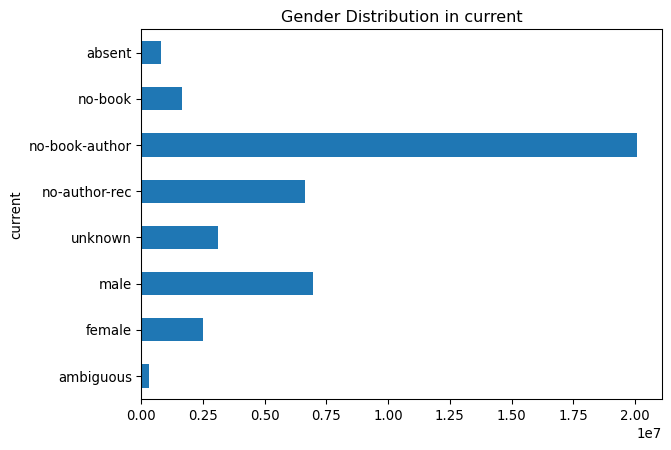

In [32]:
plot_gender('current')